## DBA 학습자 수료 예측
- data set 구성
  - 개인정보: 학교, 전공, 학년 등
  - 학습 관련: 하루 공부 시간, 수강 분반 등
  - 목표 관련: 희망 진로, 자격증 등
  - 기타: 조별활동 선호도, 유입 경로, 재등록 여부 등
- 랜덤 포레스트 사용
  - 이상치에 강한 알고리즘

In [120]:
# 기본 베이스라인

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 사용

In [121]:
# Data 로드

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [122]:
train.head()

,ID,generation,school1,major type,major1_1,major1_2,major_data,job,class1,class2,class3,class4,re_registration,contest_award,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,previous_class_3,previous_class_4,previous_class_5,previous_class_6,previous_class_7,major_field,desired_career_path,completed_semester,project_type,time_input,desired_job,certificate_acquisition,desired_certificate,certificate_study_period,desired_job_except_data,incumbents_level,incumbents_lecture,incumbents_company_level,incumbents_lecture_type,incumbents_lecture_scale,incumbents_lecture_scale_reason,interested_company,expected_domain,contest_participitation,idea_contest,onedayclass_topic,withdrawal
0,TRAIN_0000,8,3e0057be3ecde495d1d6aab0bdc3092cce94440a6a4f68...,단일 전공,IT(컴퓨터 공학 포함),NaN,False,대학생,4,NaN,NaN,NaN,아니요,NaN,내국인,에브리타임,"BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)",프로젝트 경험,네. 오프라인으로 참여하고 싶어요,NaN,NaN,NaN,NaN,NaN,공학 (컴퓨터 공학 제외),취업,대학교 이수학기 4학기 이하,팀,4.5,데이터 엔지니어,없음,"SQLD, 정보처리기사",시험일 전 4주 (2/1 ~ 2/27),개발,주니어 (0~3년차),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)","온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,인원이 너무 많지 않아야 편하게 들을 수 있어서,삼성이나 하이닉스,AI,NaN,NaN,C++ 응용,1
1,TRAIN_0001,8,c7c76d1a4c9d719d17c899a3ca9de153452a22163fe083...,"복수 전공 ( 다중전공, 이중전공 포함 )",IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),False,대학생,4,NaN,NaN,NaN,아니요,NaN,내국인,에브리타임,혼자 공부하기 어려워서,프로젝트 경험,네. 오프라인으로 참여하고 싶어요,NaN,NaN,NaN,NaN,NaN,IT (컴퓨터 공학 포함),취업,대학교 이수학기 5학기 이상,팀,2.0,인공지능 전문가,없음,"ADsP, SQLD, 빅데이터 분석 기사",시험일 전 4주 (2/1 ~ 2/27),AI,주니어 (0~3년차),직무 강의 (예시: 실무 진행 방식 및 직무 준비생을 위한 팁),국내 빅테크 IT 계열 (네카쿠라배당토),"온,오프라인 동시",10명 내외의 강의 리스너와 1명의 현직자,인원이 적어야 집중할 수 있고 질문 하기 쉽다.,네이버,AI,NaN,NaN,.,1
2,TRAIN_0002,8,1ed9296bd2a05ea36fabb5171a003b7320bb21a53d6135...,단일 전공,IT(컴퓨터 공학 포함),NaN,True,대학생,4,NaN,NaN,NaN,아니요,NaN,내국인,에브리타임,혼자 공부하기 어려워서,데이터 분석 역량,네. 오프라인으로 참여하고 싶어요,NaN,NaN,NaN,NaN,NaN,IT (컴퓨터 공학 포함),취업,대학교 이수학기 4학기 이하,팀,3.0,데이터 분석가,없음,빅데이터 분석 기사,시험일 전 4주 (2/1 ~ 2/27),AI,시니어 (10년차 ~),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)","온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,너무 소수인원은 조금 부담스럽고 너무 많은 인원은 집중도가 떨어질거같아서,스포츠분석 기업,AI,139ac02d03d83f839197195e65bc1810ef5282ade32d80...,NaN,C언어 기초,1
3,TRAIN_0003,8,5ec50ef5a0c0416652f8d67a89ef4c02eb0c6a61b5d0a8...,단일 전공,IT(컴퓨터 공학 포함),NaN,True,대학생,7,NaN,NaN,NaN,아니요,NaN,내국인,에브리타임,현직자의 강의를 듣고 싶어서,데이터 분석 역량,네. 온라인으로 참여하고 싶어요,NaN,NaN,NaN,NaN,NaN,자연과학,취업,대학교 이수학기 5학기 이상,팀,2.0,데이터 분석가,컴퓨터활용능력,"ADsP, SQLD, 빅데이터 분석 기사, 정보처리기사",시험일 전 4주 (2/1 ~ 2/27),AI,주니어 (0~3년차),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),국내 빅테크 IT 계열 (네카쿠라배당토),"온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,너무 많은 인원이 있을 경우 집중도가 떨어질 거 같습니다.,토스,AI,NaN,NaN,현직자의 취업과정,0
4,TRAIN_0004,8,c7c76d1a4c9d719d17c899a3ca9de153452a22163fe083...,"복수 전공 ( 다중전공, 이중전공 포함 )",IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),False,대학생,7,NaN,NaN,NaN,아니요,NaN,내국인,에브리타임,혼자 공부하기 어려워서,공모전 경험,네. 오프라인으로 참여하고 싶어요,NaN,NaN,NaN,NaN,NaN,"IT (컴퓨터 공학 포함), 인문학",취업,대학교 이수학기 5학기 이상,팀,1.5,데이터 분석가,SQLD,"ADsP, 빅데이터 분석 기사, 정보처리기사",시험일 전 4주 (2/1 ~ 2/27),개발,주니어 (0~3년차),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)",오프라인,100명 이상의 리스너와 10명 이상의 현직자,많은 현직자분들의 이야기를 듣고싶어서,네이버 카카오,금융,NaN,NaN,C언어,1


In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               1056 non-null   object 
 1   generation                       1056 non-null   int64  
 2   school1                          1056 non-null   object 
 3   major type                       1049 non-null   object 
 4   major1_1                         1051 non-null   object 
 5   major1_2                         493 non-null    object 
 6   major_data                       1056 non-null   bool   
 7   job                              1056 non-null   object 
 8   class1                           1056 non-null   int64  
 9   class2                           101 non-null    float64
 10  class3                           2 non-null      float64
 11  class4                           1 non-null      float64
 12  re_registration     

In [124]:
# 전처리(1): 빈 값 비율이 큰 컬럼 제거

missing_ratio = train.isnull().mean()
columns_to_drop = missing_ratio[missing_ratio > 0.7].index.tolist()

train = train.drop(columns = columns_to_drop, axis=1)
test = test.drop(columns = columns_to_drop, axis=1)

In [125]:
train.head()

,ID,generation,school1,major type,major1_1,major1_2,major_data,job,class1,re_registration,nationality,inflow_route,whyBDA,what_to_gain,hope_for_group,major_field,desired_career_path,completed_semester,project_type,time_input,desired_job,certificate_acquisition,desired_certificate,certificate_study_period,desired_job_except_data,incumbents_level,incumbents_lecture,incumbents_company_level,incumbents_lecture_type,incumbents_lecture_scale,incumbents_lecture_scale_reason,interested_company,expected_domain,onedayclass_topic,withdrawal
0,TRAIN_0000,8,3e0057be3ecde495d1d6aab0bdc3092cce94440a6a4f68...,단일 전공,IT(컴퓨터 공학 포함),NaN,False,대학생,4,아니요,내국인,에브리타임,"BDA 학회원만의 혜택을 누리고 싶어서(현직자 강연, 잡 페스티벌, 기업연계 공모전 등)",프로젝트 경험,네. 오프라인으로 참여하고 싶어요,공학 (컴퓨터 공학 제외),취업,대학교 이수학기 4학기 이하,팀,4.5,데이터 엔지니어,없음,"SQLD, 정보처리기사",시험일 전 4주 (2/1 ~ 2/27),개발,주니어 (0~3년차),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)","온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,인원이 너무 많지 않아야 편하게 들을 수 있어서,삼성이나 하이닉스,AI,C++ 응용,1
1,TRAIN_0001,8,c7c76d1a4c9d719d17c899a3ca9de153452a22163fe083...,"복수 전공 ( 다중전공, 이중전공 포함 )",IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),False,대학생,4,아니요,내국인,에브리타임,혼자 공부하기 어려워서,프로젝트 경험,네. 오프라인으로 참여하고 싶어요,IT (컴퓨터 공학 포함),취업,대학교 이수학기 5학기 이상,팀,2.0,인공지능 전문가,없음,"ADsP, SQLD, 빅데이터 분석 기사",시험일 전 4주 (2/1 ~ 2/27),AI,주니어 (0~3년차),직무 강의 (예시: 실무 진행 방식 및 직무 준비생을 위한 팁),국내 빅테크 IT 계열 (네카쿠라배당토),"온,오프라인 동시",10명 내외의 강의 리스너와 1명의 현직자,인원이 적어야 집중할 수 있고 질문 하기 쉽다.,네이버,AI,.,1
2,TRAIN_0002,8,1ed9296bd2a05ea36fabb5171a003b7320bb21a53d6135...,단일 전공,IT(컴퓨터 공학 포함),NaN,True,대학생,4,아니요,내국인,에브리타임,혼자 공부하기 어려워서,데이터 분석 역량,네. 오프라인으로 참여하고 싶어요,IT (컴퓨터 공학 포함),취업,대학교 이수학기 4학기 이하,팀,3.0,데이터 분석가,없음,빅데이터 분석 기사,시험일 전 4주 (2/1 ~ 2/27),AI,시니어 (10년차 ~),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)","온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,너무 소수인원은 조금 부담스럽고 너무 많은 인원은 집중도가 떨어질거같아서,스포츠분석 기업,AI,C언어 기초,1
3,TRAIN_0003,8,5ec50ef5a0c0416652f8d67a89ef4c02eb0c6a61b5d0a8...,단일 전공,IT(컴퓨터 공학 포함),NaN,True,대학생,7,아니요,내국인,에브리타임,현직자의 강의를 듣고 싶어서,데이터 분석 역량,네. 온라인으로 참여하고 싶어요,자연과학,취업,대학교 이수학기 5학기 이상,팀,2.0,데이터 분석가,컴퓨터활용능력,"ADsP, SQLD, 빅데이터 분석 기사, 정보처리기사",시험일 전 4주 (2/1 ~ 2/27),AI,주니어 (0~3년차),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),국내 빅테크 IT 계열 (네카쿠라배당토),"온,오프라인 동시",3~50명 내외의 강의 리스너와 1명의 현직자,너무 많은 인원이 있을 경우 집중도가 떨어질 거 같습니다.,토스,AI,현직자의 취업과정,0
4,TRAIN_0004,8,c7c76d1a4c9d719d17c899a3ca9de153452a22163fe083...,"복수 전공 ( 다중전공, 이중전공 포함 )",IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),False,대학생,7,아니요,내국인,에브리타임,혼자 공부하기 어려워서,공모전 경험,네. 오프라인으로 참여하고 싶어요,"IT (컴퓨터 공학 포함), 인문학",취업,대학교 이수학기 5학기 이상,팀,1.5,데이터 분석가,SQLD,"ADsP, 빅데이터 분석 기사, 정보처리기사",시험일 전 4주 (2/1 ~ 2/27),개발,주니어 (0~3년차),커리어 패스 과정 (예시: 비전공자/전공자의 취업 준비 및 이직 과정),"국내 대기업 IT 계열 (금융, 제조 ...)",오프라인,100명 이상의 리스너와 10명 이상의 현직자,많은 현직자분들의 이야기를 듣고싶어서,네이버 카카오,금융,C언어,1


In [126]:
missing_cols = train.columns[train.isnull().any()].tolist()

In [127]:
missing_cols # null값 확인

['major type',
 'major1_1',
 'major1_2',
 'what_to_gain',
 'hope_for_group',
 'major_field',
 'desired_career_path',
 'completed_semester',
 'project_type',
 'desired_job',
 'desired_certificate',
 'certificate_study_period',
 'desired_job_except_data',
 'incumbents_level',
 'incumbents_lecture',
 'incumbents_company_level',
 'incumbents_lecture_type',
 'incumbents_lecture_scale',
 'incumbents_lecture_scale_reason',
 'interested_company',
 'expected_domain',
 'onedayclass_topic']

In [128]:
# 전처리(2): null값 일괄처리

for col in missing_cols:
    mode_value = train[col].mode()[0] # 최빈갑 사용
    train[col] = train[col].fillna(mode_value)
    test[col] = test[col].fillna(mode_value)

In [129]:
# 전처리(3): 이진 변수 생성
# IT 기준 전공 분류

train['is_major_it'] = train['major_field'].str.contains('IT', regex=True).astype(int)
test['is_major_it'] = test['major_field'].str.contains('IT', regex=True).astype(int)

In [130]:
# 문자 컬럼 확인
object_columns = train.select_dtypes(['object', 'bool']).columns

In [131]:
# 전처리(4): 문자열 처리

label_enc = {}
for col in object_columns:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    # 문자열로 통일
    
    le = LabelEncoder()
    le = le.fit(train[col])
    train[col] = le.transform(train[col])
    
    for label in np.unique(test[col]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    
    test[col] = le.transform(test[col])
    label_enc[col] = le

<AxesSubplot:>

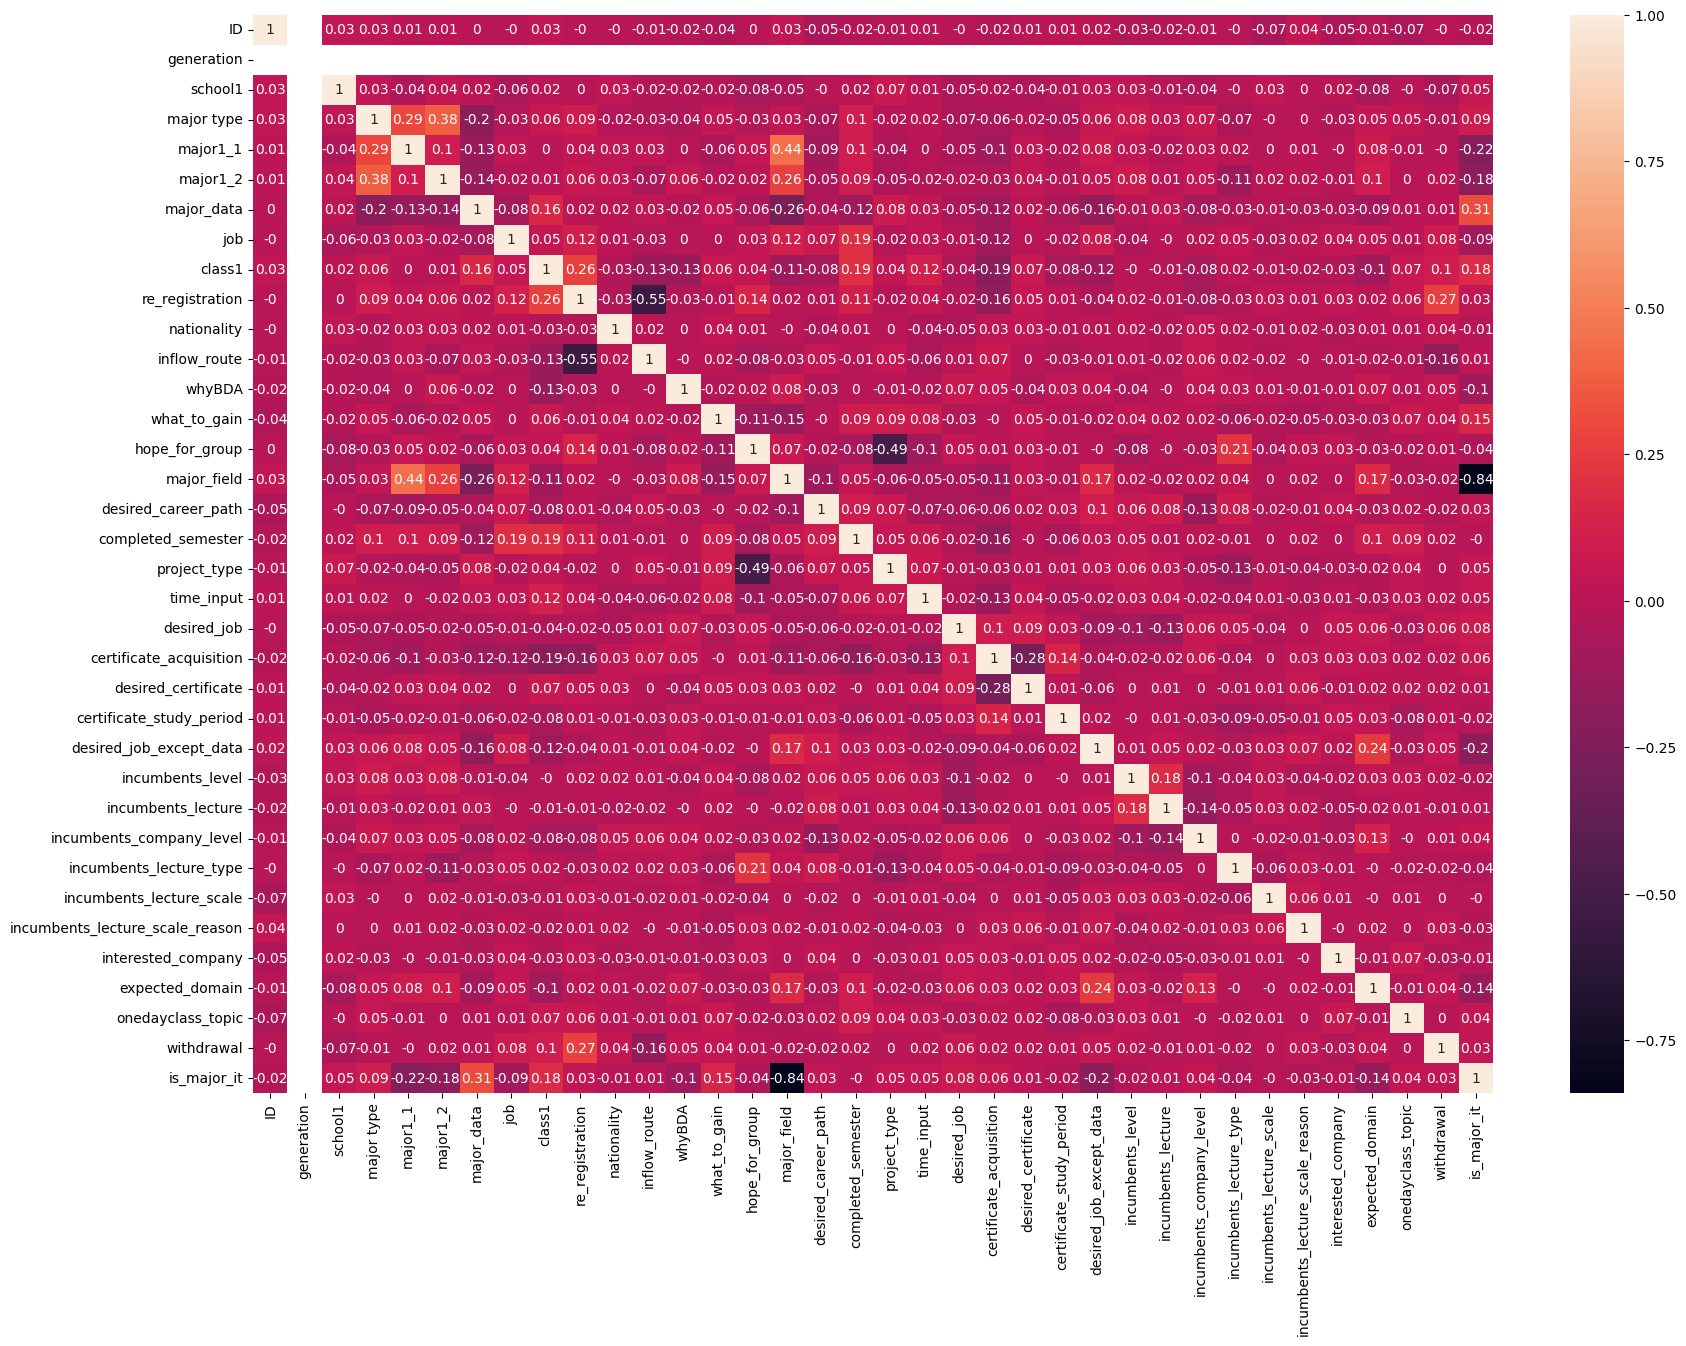

In [132]:
# EDA
# heatmap 확인 -> 최종적으로 사용할 변수 선택

plt.figure(figsize = (20,14))
sns.heatmap(train.corr().round(2), annot = True)

In [137]:
# 속성 선택 (시간 투자, IT 관련 전공 여부, 재수강 여부)

X_train = train[['time_input', 'is_major_it', 're_registration']]
y_train = train['withdrawal']

X_test = test[['time_input', 'is_major_it', 're_registration']]

In [138]:
# 모델링 진행 (RandomFrest)

model = RandomForestClassifier(random_state = 50)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [139]:
# 예측 실행

pred = model.predict(X_test)

In [140]:
# Submission 파일 생성

submission = pd.read_csv('sample_submission.csv')
submission['withdrawal'] = pred
submission.to_csv('submit.csv', index = False)